# Utilisation de l'API Twitter v2

Pour utiliser l'interface de programmation mise à disposition par Twitter pour récupérer des données de tweets, il faut disposer d'un [compte "Developer" Twitter](https://developer.twitter.com/en) avec **Elevated Access** (ce qui demande au préalable la [création d'un compte Twitter](https://help.twitter.com/fr/using-twitter/create-twitter-account)). Au moment de la demande d'accès, il faut indiquer dans un formulaire quelle utilisation sera faite des données récupérées via l'API de Twitter et préciser si elles seront mises à disposition d'un organisme gouvernemental. L'accès est donné immédiatement (en donnant une description claire de l'utilisation des données et en répondant **"non"** pour le second point).

L'**Elevated Access** donne les possibilités suivantes :
- 2M tweets récupérables par mois;
- 1 projet;
- 3 applications pour ce projet.

Chaque application donne la possibilité de générer des identifiants/tokens pour utiliser les différents endpoints de l'API. Il y a des limites sur le nombre de requêtes envoyables à l'API par période de 15 minutes. Ces limites dépendent de l'endpoint concerné mais aussi du mode d'authentification utilisé. La documentation se trouve [ici](https://developer.twitter.com/en/docs/twitter-api/rate-limits).

À noter qu'un endpoint souvent utilisé est le `Tweet lookup` qui permet de récupérer toutes les données d'un tweet à partir d'un identifiant unique. La limite de 2M de tweets récupérables par mois ne concerne pas cette fonctionnalité, mais cette dernière est tout de même soumise à une limite de 900 requêtes (de 100 identifiants maximum) par période de 15 minutes.

### Faire une requête grâce à la librairie `twarc`

La librairie `twarc` fournit une interface entre `Python` et l'API de Twitter. Pour utiliser les fonctions implémentées par la librairie, il faut disposer d'identifiants. Une fois l'accès au portail "Developer" obtenu (voir ci-dessus), on peut obtenir ces identifiants en créant un *Projet* et une *App* sur le portail. Au moment de la création de l'*App*, Twitter fournit les identifiants qu'il faut sauvegarder quelque part (si on les perd, il faut en générer de nouveaux):
- Une clé;
- Une clé secrète;
- Un *bearer token*.

Sur le SSP Cloud, il est possible de stocker ces identifiants dans un [secret Vault](https://datalab.sspcloud.fr/my-secrets/). Pour ce faire, il faut créer un secret et ajouter 3 variables à ce secret, avec les noms **TWITTER_KEY** pour la clé, **TWITTER_KEY_SECRET** pour la clé secrète, **TOKEN** pour le bearer token (ces noms de variables permettent d'utiliser le code ci-dessous tel quel). On utilise la librairie `hvac` pour accéder aux secrets Vault. 

In [1]:
import os
import hvac

client = hvac.Client(url='https://vault.lab.sspcloud.fr',
                     token=os.environ['VAULT_TOKEN'])
client.is_authenticated()  

True

In [2]:
secret = os.environ['VAULT_MOUNT'] + os.environ['VAULT_TOP_DIR'] + '/twitter'
mount_point, secret_path = secret.split('/', 1)
secret_dict = client.secrets.kv.read_secret_version(path=secret_path, mount_point = mount_point)

On récupère les clés et token pour pouvoir utiliser twarc.

In [3]:
TWITTER_TOKEN = secret_dict['data']['data']['TOKEN']
TWITTER_KEY = secret_dict['data']['data']['TWITTER_KEY']
TWITTER_KEY_SECRET = secret_dict['data']['data']['TWITTER_KEY_SECRET']

L'authentification à Twitter est possible maintenant : on initialise un client twarc pour pouvoir faire des appels à l'API.

In [4]:
from twarc import Twarc2

t_inst = Twarc2(consumer_key=TWITTER_KEY, consumer_secret=TWITTER_KEY_SECRET, bearer_token=TWITTER_TOKEN)

Pour construire une requête, il faut suivre la documentation de l'API Twitter qui est très complète, c.f. par exemple [ce tutoriel](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query) (ou [cette page](https://developer.twitter.com/en/docs/tutorials/building-high-quality-filters) sur la construction de filtres). La méthode `search_recent` de la librairie encapsule un appel à l'endpoint `tweets/search/recent` de Twitter pour récupérer des tweets des 7 derniers jours qui correspondent à une requête donnée. À noter que pour pouvoir accéder à l'endpoint *Full-archive search* qui permet de récupérer des tweets peu importe leur date de publication, il faut disposer d'un accès **Academic Research** qui demande la constitution d'un dossier.

Avec l'**Elevated Access**, les requêtes peuvent aller jusqu'à 512 caractères et intégrer un certain nombre d'opérateurs. La documentation mentionnée ci-dessus donne un exemple de requête, qui concerne des tweets avec une information géographique (`has:geo`), provenant d'agences météorologiques du Texas et qui ne sont pas des retweets. Cette requête aurait pu servir à récupérer les tweets sur le cyclone Harvey qui s'était abbatu sur Houston en 2017 :

`has:geo (from:NWSNHC OR from:NHC_Atlantic OR from:NWSHouston OR from:NWSSanAntonio OR from:USGS_TexasRain OR from:USGS_TexasFlood OR from:JeffLindner1) -is:retweet`

On récupère ci-dessous un unique batch de 10 tweets contenant le mot "climatique", qu'on place dans un fichier csv grâce à la librairie `twarc_csv`.

In [7]:
import json
import datetime
from twarc_csv import CSVConverter

start_time = datetime.datetime.now(datetime.timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)
tweets_fr = t_inst.search_recent(query="climatique", start_time=start_time, max_results=10)

for i, page in enumerate(tweets_fr):
    with open("data/tweets_climatique.jsonl", "w+") as f:
        f.write(json.dumps(page) + "\n")
    break
with open("data/tweets_climatique.jsonl", "r") as infile:
    with open("data/tweets_climatique.csv", "w") as outfile:
        converter = CSVConverter(infile, outfile)
        converter.process()
        
os.remove("data/tweets_climatique.jsonl")

  0%|          | Processed 0.00/44.6k of input file [00:00<?, ?B/s]

In [8]:
import pandas as pd

df = pd.read_csv("data/tweets_climatique.csv")
df.columns

Index(['id', 'conversation_id', 'referenced_tweets.replied_to.id',
       'referenced_tweets.retweeted.id', 'referenced_tweets.quoted.id',
       'edit_history_tweet_ids', 'edit_controls.edits_remaining',
       'edit_controls.editable_until', 'edit_controls.is_edit_eligible',
       'author_id', 'in_reply_to_user_id', 'retweeted_user_id',
       'quoted_user_id', 'created_at', 'text', 'lang', 'source',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.reply_count', 'public_metrics.retweet_count',
       'reply_settings', 'possibly_sensitive', 'withheld.scope',
       'withheld.copyright', 'withheld.country_codes', 'entities.annotations',
       'entities.cashtags', 'entities.hashtags', 'entities.mentions',
       'entities.urls', 'context_annotations', 'attachments.media',
       'attachments.media_keys', 'attachments.poll.duration_minutes',
       'attachments.poll.end_datetime', 'attachments.poll.id',
       'attachments.poll.options', 'attachm

In [9]:
df.text[:10]

0    Dérèglement climatique : "Il faut comprendre a...
1    Une tornade dans les haut de France \nContinue...
2    – Le pessimisme (pensez au catastrophisme fina...
3    🛣️ #Autoroute → 110 km/h pour la sobriété éner...
Name: text, dtype: object

Vous pouvez maintenant récupérer des données par vous-mêmes avec des requêtes plus élaborées que celle-ci !

### Hydratation de tweets

Beaucoup de collections de tweets sont disponibles en libre accès sur Internet, car il est assez coûteux de suivre un sujet particulier sur une longue période de temps sans un accès de type **Academic Research** : sans cet accès seuls les tweets des 7 derniers jours peuvent être récupérés.

Par exemple [cet article de blog](https://imerit.net/blog/top-25-twitter-datasets-for-natural-language-processing-and-machine-learning-all-pbm/) recense 25 collections de tweets disponibles sur Internet, et on peut trouver sur [cette page](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/5QCCUU) un dataset de 40M de tweets - constitué par des chercheurs de la George Washington University - postés entre 2017 et 2019 sur le sujet du changement climatique. Plus précisément, les tweets ciblés sont ceux contenant les [hashtags](https://help.twitter.com/fr/using-twitter/how-to-use-hashtags) ou les chaînes de caractères suivants :
- #climatechange; 
- #climatechangeisreal;
- #actonclimate;
- #globalwarming;
- #climatechangehoax;
- #climatedeniers;
- #climatechangeisfalse;
- #globalwarminghoax;
- #climatechangenotreal;
- climate change;
- global warming;
- climate hoax.

Pour une collection importantes de tweets, Twitter déconseille de mettre toutes les données en libre accès, et recommande de ne publier que les identifiants des tweets en question. L'endpoint `Tweet lookup` de l'API permet de récupérer toutes les données d'une collection de tweets à partir de leurs identifiants (avec seulement une *rate limit* de 900 requêtes toutes les 15 minutes). On récupère une partie du dataset de 40M de tweets et on utilise la méthodes `tweet_lookup` de `twarc` pour récupérer tout le contenu des tweets.

In [10]:
with open('data/climate_id.txt.00') as f:
    lines = f.read().splitlines()
    
lines[:5]

['1028954284157808641',
 '1028954283822260225',
 '1028954290893799428',
 '1028954291900489728',
 '1028954309004685312']

In [11]:
sample_tweets = t_inst.tweet_lookup(lines[:5])

sample_tweets

<generator object Twarc2.tweet_lookup at 0x7fcdc7e58cf0>

In [12]:
sample_tweets_list = list(sample_tweets)
sample_tweets_list[0].keys()

dict_keys(['data', 'includes', 'errors', '__twarc'])

La méthode `tweet_lookup` renvoie un générateur de batchs de tweets (le maximum de tweets par batch est de 100 tweets). Un batch de $n$ tweets est représenté par un dictionnaire comportant 4 clés :
- La clé `'data'` est associée à une liste de longueur $n$, avec chaque élément correspondant à un tweet du batch. Un tweet est représenté par un dictionnaire, dont les clés-valeurs incluent  :
    - `'reference_tweets'` : Liste d'identifiants de tweets référencés dans le tweet. Pour chaque tweet référencé il y a de l'information sur le type de référence (par exemple si le tweet est cité, retweeté avec un commentaire, etc.) ;
    - `'conversation_id'` : Identifiant de la conversation à laquelle appartient le tweet : parfois identique à l'identifiant du tweet (si le tweet est à l'origine d'une conversation ?) ;
    - `'entities'` : Dictionnaire contenant les entités qui apparaissent dans le tweet. Peut contenir des url, des mentions, des annotations (par exemple des lieux qui apparaissent dans le tweet), des hashtags, etc. ;
    - `'reply_settings'` : String qui indique les paramètres de réponse au tweet (par exemple prend la valeur 'everyone' si tout le monde peut répondre au tweet) ;
    - `'created_at'` : String qui indique la date et l'heure auxquelles le tweet a été créé ;
    - `'author_id'` : Identifiant de l'auteur du tweet ;
    - `'possibly_sensitive'` : Booléen qui indique si le contenu du tweet est potentiellement sensible ;
    - `'text'` : Contenu du tweet (UTF-8) ;
    - `'source'` : String qui indique d'où le tweet a été envoyé (par exemple 'Twitter Web Client') ;
    - `'public_metrics'` : Dictionnaire qui donne le nombre de retweets, de réponses, de likes et de citations ;
    - `'id'` : Identifiant du tweet ;
    - `'lang'` : Langage du tweet ;
- La clé `'includes'` est associée à un dictionnaire, qui contient 3 clés : `'users'`, `'tweets'`, `'media'`. La clé `'users'` a pour valeur une liste d'utilisateurs en lien avec les tweets du batch. Un utilisateur est un dictionnaire dont les clés-valeurs incluent :
    - `'description'` : Description du profil ;
    - `'location'` : Localisation du profil ;
    - `'profile_image_url'` : Url de la photo de profil ;
    - `'verified'` : Booléen qui indique si le compte est vérifié;
    - `'name'` : Nom du profil ;
    - `'url'` : Url du profil ;
    - `'username'` : Nom d'utilisateur ;
    - `'entities'` : Entités qui apparaissent sur le profil ;
    - `'public_metrics'` : Nombre de followers, de comptes suivis, de tweets publiés, etc. ;
    - `'id'` : Identifiant du profil ;
    - `'pinned_tweet_id'` : Identifiant du tweet épinglé du profil ;
    - `'created_at'` : Date et heure de création du profil ;
    - `'protected'` : Boolean qui indique si le profil est protégé ;
- La clé `'errors'` est associée à une liste d'erreurs (par exemple lorsque des tweets n'ont pas été retrouvés) ;
- La clé `'__twarc'` correspond à la requête faite par twarc à partir de la liste d'ids donnée à la méthode `tweet_lookup`.

La fonction suivante prend en entrée un fichier texte avec des identifiants de tweets et utilise la méthode `tweet_lookup` pour récupérer toutes les données correspondantes. Les données concernant les tweets et leurs utilisateurs sont ensuite dumpées dans un fichier `json`.

In [13]:
from typing import List
import json

def hydrate_tweets(t_inst, ids: List[str], outfile: str) -> None:
    """
    Hydrates tweets and saves result into a json file.
    
    Args:
        t_inst: Twarc instance.
        ids (List[str]): List of tweets ids.
        outfile (str): Path name of the json outfile.
    """
    sample_tweets = t_inst.tweet_lookup(ids)

    tweet_list = []
    for batch_number, batch in enumerate(sample_tweets):
        tweet_data = batch['data']
        user_data = batch['includes']['users']

        user_dict = {user['id']: user for user in user_data}

        for tweet in tweet_data:
            _id = tweet.pop('id')
            try:
                user_info = user_dict[tweet['author_id']]
                del user_info['id']
                tweet['author'] = user_info
            except:
                pass
            tweet_list.append({'_id': _id, '_source': tweet})

        # Dump
        with open(outfile, 'w') as f:
            json.dump(tweet_list, f)
    print('All data has been dumped.')
    return

In [14]:
hydrate_tweets(t_inst, lines[:5000], "data/small_dataset_global_warming.json")

All data has been dumped.


On peut récupérer les données dans un `pandas.DataFrame` simplement à l'aide de la fonction `json_normalize`.

In [15]:
data = json.load(open("data/small_dataset_global_warming.json"))
df = pd.json_normalize(data)

In [16]:
df.shape

(3345, 49)

In [17]:
df.head()

,_id,_source.author_id,_source.edit_history_tweet_ids,_source.text,_source.referenced_tweets,_source.lang,_source.possibly_sensitive,_source.created_at,_source.conversation_id,_source.entities.mentions,...,_source.in_reply_to_user_id,_source.withheld.copyright,_source.withheld.country_codes,_source.author.withheld.country_codes,_source.entities.hashtags,_source.author.entities.description.urls,_source.author.entities.description.mentions,_source.geo.place_id,_source.entities.cashtags,_source.attachments.poll_ids
0,1028954283822260225,1022750460086820864,[1028954283822260225],An eye-opening article. This further reinforce...,"[{'type': 'quoted', 'id': '1026334769838211072'}]",en,False,2018-08-13T10:39:52.000Z,1028954283822260225,"[{'start': 108, 'end': 118, 'username': 'Eamon...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1028954290893799428,71834468,[1028954290893799428],Bangladesh Confronts Climate Change - book goe...,NaN,en,False,2018-08-13T10:39:54.000Z,1028954290893799428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1028954309004685312,803391058411331584,[1028954309004685312],RT @MrDenmore: If there’s a definition of insa...,"[{'type': 'retweeted', 'id': '1028911195145695...",en,False,2018-08-13T10:39:58.000Z,1028954309004685312,"[{'start': 3, 'end': 13, 'username': 'MrDenmor...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1028954309919158272,13886002,[1028954309919158272],RT @KateAronoff: The scene in Jurassic Park wh...,"[{'type': 'retweeted', 'id': '1028467362075471...",en,False,2018-08-13T10:39:59.000Z,1028954309919158272,"[{'start': 3, 'end': 15, 'username': 'KateAron...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1028954312234422273,3090116309,[1028954312234422273],RT @KateAronoff: The scene in Jurassic Park wh...,"[{'type': 'retweeted', 'id': '1028467362075471...",en,False,2018-08-13T10:39:59.000Z,1028954312234422273,"[{'start': 3, 'end': 15, 'username': 'KateAron...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.columns

Index(['_id', '_source.author_id', '_source.edit_history_tweet_ids',
       '_source.text', '_source.referenced_tweets', '_source.lang',
       '_source.possibly_sensitive', '_source.created_at',
       '_source.conversation_id', '_source.entities.mentions',
       '_source.entities.urls', '_source.public_metrics.retweet_count',
       '_source.public_metrics.reply_count',
       '_source.public_metrics.like_count',
       '_source.public_metrics.quote_count',
       '_source.edit_controls.edits_remaining',
       '_source.edit_controls.is_edit_eligible',
       '_source.edit_controls.editable_until', '_source.source',
       '_source.reply_settings', '_source.author.description',
       '_source.author.username', '_source.author.protected',
       '_source.author.created_at', '_source.author.profile_image_url',
       '_source.author.location',
       '_source.author.public_metrics.followers_count',
       '_source.author.public_metrics.following_count',
       '_source.author.public_

### Analyse du contenu de tweets

On récupère des tweets récents ayant pour sujet la statistique publique, afin de pouvoir analyser leur contenu.

In [21]:
tweets_stats = t_inst.search_recent(query='\"official statistics\" -is:retweet', max_results=100)

for i, page in enumerate(tweets_stats):
    with open("data/tweets_stats.jsonl", "w+") as f:
        f.write(json.dumps(page) + "\n")
    break
with open("data/tweets_stats.jsonl", "r") as infile:
    with open("data/tweets_stats.csv", "w") as outfile:
        converter = CSVConverter(infile, outfile)
        converter.process()
        
os.remove("data/tweets_stats.jsonl")

  0%|          | Processed 0.00/645k of input file [00:00<?, ?B/s]

In [22]:
import pandas as pd

df = pd.read_csv("data/tweets_stats.csv")

In [23]:
df.text[:10]

0    @arwicken @EurekaJustice @mollycrabapple No, y...
1    @nathaliejacoby1 0 (Null) It's pseudo research...
2    Some official statistics put unemployment at a...
3    Official statistics show that nearly 2.5 milli...
4    #NEW: As the 2022 State Fair of Texas comes to...
5    Where do you get your statistics from?\nDo you...
6    Official statistics show that nearly 2.5 milli...
7    @LaBreezercabra @iamyesyouareno Noble attempt,...
8    @PengusK @incelswiki Of course, we should all ...
9    @EricTopol @OurWorldInData Dr. John Campbell c...
Name: text, dtype: object

On voudrait avoir un aperçu du contenu des tweets. On va faire un wordcloud pour avoir une première visualisation.

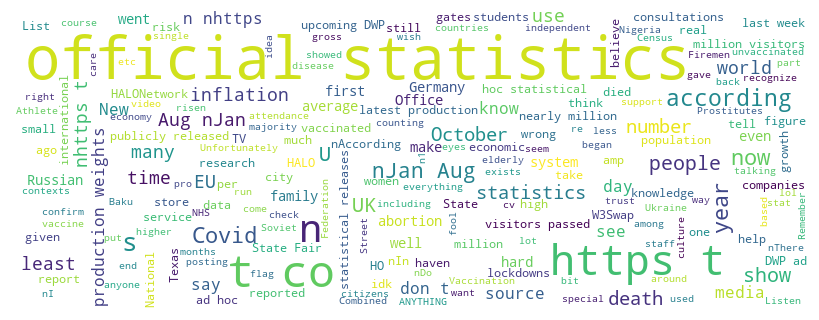

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color ='white',
    min_font_size = 1
).generate(' '.join(df.text)) 

# plot the WordCloud image
plt.figure(figsize = (8, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Nettoyage : on retire la ponctuation, les mots commençant par @, les url, les occurrences de "official statistics", etc.

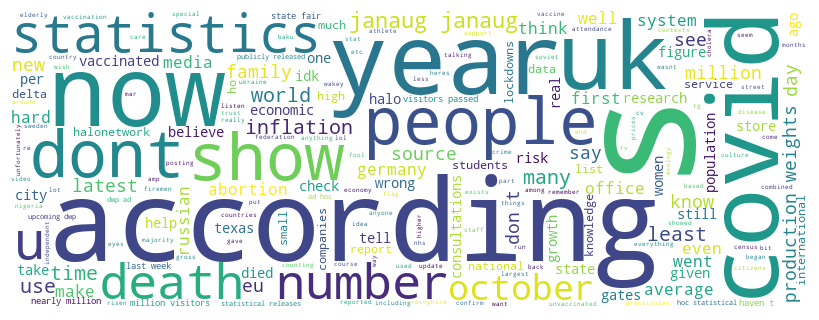

In [80]:
import re
import string
from string import punctuation

my_punctuation = punctuation.replace("@", "")

def preprocess(text: str):
    new_text = []
    
    clean_text = ' '.join(text.split('\\n')).lower()
    clean_text = re.sub(r'[0-9]+', '', clean_text)
    clean_text = clean_text.translate(str.maketrans("", "", my_punctuation))
    clean_text = re.sub(r'official statistics', '', clean_text)
    clean_text = re.sub('\s\s+', ' ', clean_text)
    for t in clean_text.split(' '):
        if t.startswith('@') and len(t) > 1: continue
        if t.startswith('http'): continue
        if t == '(Null)': continue
        new_text.append(t)
    return " ".join(new_text)

texts = [preprocess(text) for text in df.text]
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color ='white',
    min_font_size = 1
).generate(' '.join(texts)) 

# plot the WordCloud image
plt.figure(figsize = (8, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

On a déjà nettoyé un peu le jeu de données, maintenant on souhaite retirer les mots vides de sens pour avoir accès aux mots signifiants du jeu de données. Ces mots vides de sens sont appelés en anglais "stopwords". La librairie `nltk` fournit des listes standards de "stopwords" dans plusieurs langues.

In [82]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [83]:
from nltk.corpus import stopwords as ntlk_stopwords
from nltk.tokenize import word_tokenize

stopwords = ntlk_stopwords.words("english")

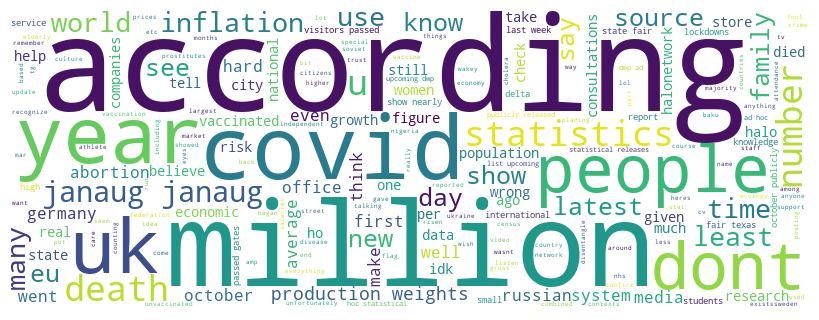

In [84]:
def remove_stopwords(text: str):
    text = [w for w in word_tokenize(text) if w not in stopwords]
    text = ' '.join(text)
    return(text)

texts = [remove_stopwords(text) for text in texts]
wordcloud = WordCloud(
    width = 800,
    height = 300,
    background_color ='white',
    min_font_size = 1
).generate(' '.join(texts)) 

# plot the WordCloud image
plt.figure(figsize = (8, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

On pourrait aller beaucoup plus loin dans la réduction de dimension mais on a déjà ici une idée des mots signifiants qui reviennent souvent dans notre petit échantillon de tweets.

## Analyse de sentiments sur des tweets

On souhaiterait avoir une idée du sentiment associé aux tweets récents publiés sur la statistique publique. L'analyse de sentiment est une tâche de classification de texte classique en NLP. Des modèles de Deep Learning sont très performants sur cette tâche lorsqu'ils sont entraînés convenablement : c'est par exemple le cas des [Transformers](https://huggingface.co/docs/transformers/index), une architecture de modèle de langage qui a des performances *state-of-the-art* sur de nombreux problèmes de NLP.

Une procédure courante aujourd'hui en NLP est de partir d'un modèle de langage complexe pré-entraîné sur un énorme corpus textuel et de l'ajuster en fonction de la tâche et des données à traiter. La tâche d'analyse de sentiment sur des tweets est tellement courante que des modèles ont été spécifiquement entraînés dans ce cadre. Les paramètres résultant de l'entraînement sont disponibles en libre accès sur Internet. Le site [Hugging Face](https://huggingface.co/) est un site qui répertorie des modèles et des jeux de données pour des tâches de Machine Learning pour les mettre à disposition de la communauté. 

Sur Hugging Face, un modèle de type Transformer (`roBERT-a`) entraîné sur 58M de tweets et ajusté pour une tâche d'analyse de sentiment (à partir des données `TweetEval`) est [disponible](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you).

Les pré-traitements à effectuer pour utiliser le mod

In [88]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


# Légers pré-traitements (on remplace les utilisateurs par "@user" et les URL par "http")
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


# Plusieurs fine-tunings ont été réalisés pour différentes tâches :
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Label mapping
labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

La fonction `predict_sentiment` utilise le modèle pré-entraîné pour prédire le sentiment d'un texte.

In [93]:
def predict_sentiment(text: str):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return np.argmax(scores)

predictions = []
for text in df.text:
    predictions.append(predict_sentiment(text))

On récupère les labels plutôt que leurs indices.

In [94]:
predictions = [labels[i] for i in predictions]

<AxesSubplot: ylabel='count'>

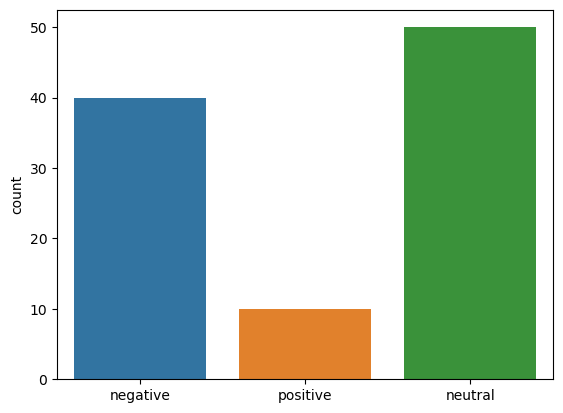

In [95]:
import seaborn as sns
sns.countplot(x=predictions)

On semble avoir de nombreux avis négatifs. On peut regarder éventuellement quels tweets sont associés à un sentiment négatif par le modèle, où s'intéresser à la variation de sentiments en fonction du temps ou de la géographie (voir l'ensemble des informations extraites de Twitter).